# ResNet 34 using TF and Keras

### 1. Import required packages

In [7]:
from __future__ import print_function
%matplotlib inline
import os
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar100, cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Packages Loaded")
print('The Tensorflow version is {}.'.format(tf.__version__))
print('The Keras version is {}.'.format(keras.__version__))
print('The Pandas version is {}.'.format(pd.__version__))
print('The Numpy version is {}.'.format(np.__version__))
print(np.__file__)

Packages Loaded
The Tensorflow version is 2.1.0.
The Keras version is 2.2.4-tf.
The Pandas version is 1.0.3.
The Numpy version is 1.18.1.
C:\ProgramData\Anaconda2\envs\TFK35\lib\site-packages\numpy\__init__.py


## ResNet for Cifrar 100 Dataset

### 1. Load the Cifar 100 dataset

C:\ProgramData\Anaconda2\envs\TFK35\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


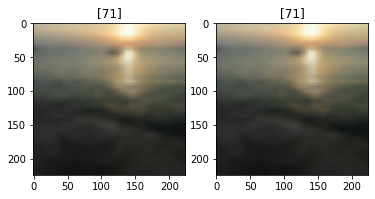

Shape of Cifar fashion train data (50000, 224, 224, 3).


In [2]:
#Download the cifar data from keras
cifar100 = tf.keras.datasets.cifar100

#Split the data between train and test data
(x_train, y_train),(x_test, y_test) = cifar100.load_data()

#Resize the images for ResNet
xc1_train = tf.image.resize(x_train, [224, 224])

#Normalize the data 
#xc1_train = xc1_train.astype('float32')
#xc1_test = xc1_test.astype('float32')
xc1_train /= 255

#xc1_train = tf.keras.utils.normalize(xc1_train, axis=1)

#Zero pad is not needed as cifar data is 32 * 32
#xf1_train = tf.pad(xf1_train, [[0, 0], [2,2], [2,2]])

# Convert class vectors to binary class matrices.
yc1_train = tf.keras.utils.to_categorical(y_train, 100)

#Display a sample image
fig = plt.figure()
_ = ax1 = plt.subplot(1,2,1)
_ = ax1.set_title(y_train[14])
_ = plt.imshow(xc1_train[14])

ax2 = plt.subplot(1,2,2)
_ = ax2.set_title(y_train[14])
_ = plt.imshow(xc1_train[14], cmap = plt.cm.binary)
_ = plt.show()

# new axis is not needed as cifar dataset is of color images having 3 channesl. 
#xc_train = xc_train[:, :, :, np.newaxis]
#xc_test = xc_test[:, :, :, np.newaxis]

#Print the shape of train and test data
print('Shape of Cifar fashion train data {}.'.format(xc1_train.shape))

In [3]:
#Repeat the above steps for test set
xc1_test = tf.image.resize(x_test, [224, 224])
xc1_test /= 255
#xc1_test = tf.keras.utils.normalize(xc1_test, axis=1)
#xf1_test = tf.pad(xf1_test, [[0, 0], [2,2], [2,2]])
yc1_test = tf.keras.utils.to_categorical(y_test, 100)
print('Shape of Cifar fashion test data {}.'.format(xc1_test.shape))

Shape of Cifar fashion test data (10000, 224, 224, 3).


### 2. Train the ResNet

In [9]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers =[
            keras.layers.Conv2D(filters,3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
            
    def call(self,inputs):
        Z=inputs
        for layer in self.main_layers:
            Z=layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, [7, 7], strides=(2, 2), input_shape=xc1_train.shape[1:], 
                                 padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="same"))

##Add residucal units
prev_filters = 64
for filters in [64] * 3 + [128] * 4 +[256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation=tf.nn.softmax))

run_id = time.strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join('logs','fit',run_id,'')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_detail = model.fit(xc1_train, yc1_train,
                  batch_size=32,
                  epochs=1,
                  callbacks=[early_stopping_cb, tensorboard_callback],
                  shuffle=True,
                  validation_split=0.2)

#plot accuracies for each epoch
history = pd.DataFrame(model_detail.history)
 
_ = history.plot(figsize=(10,5))
_ = plt.grid(True)
_ = plt.gca().set_ylim(0,1)
_ = plt.xlabel('Epochs')
_ = plt.title('CNN Cifar 100 ResNet')
_ = plt.show()

#After training the model, evaluate the test set
val_loss, val_acc = model.evaluate(xc1_test,yc1_test)
print("Validation Accuracy: "+str(val_acc))

#Print the summary of the model
model.summary()

Train on 40000 samples, validate on 10000 samples
14656/40000 [=========>....................] - ETA: 3:19:50 - loss: 4.3957 - accuracy: 0.0449

KeyboardInterrupt: 

### 3. Plot the predictions

In [12]:
wd = os. getcwd()
label_dir = os.path.join(wd,'data','Labels.csv')
print(label_dir)
cols = ["cifar100"]
label_df = pd.read_csv(label_dir)
class_names = label_df['cifarh'].tolist()

C:\Users\pmspr\Documents\Machine Learning\Computer vision\Git Repo\Convolutions\data\Labels.csv


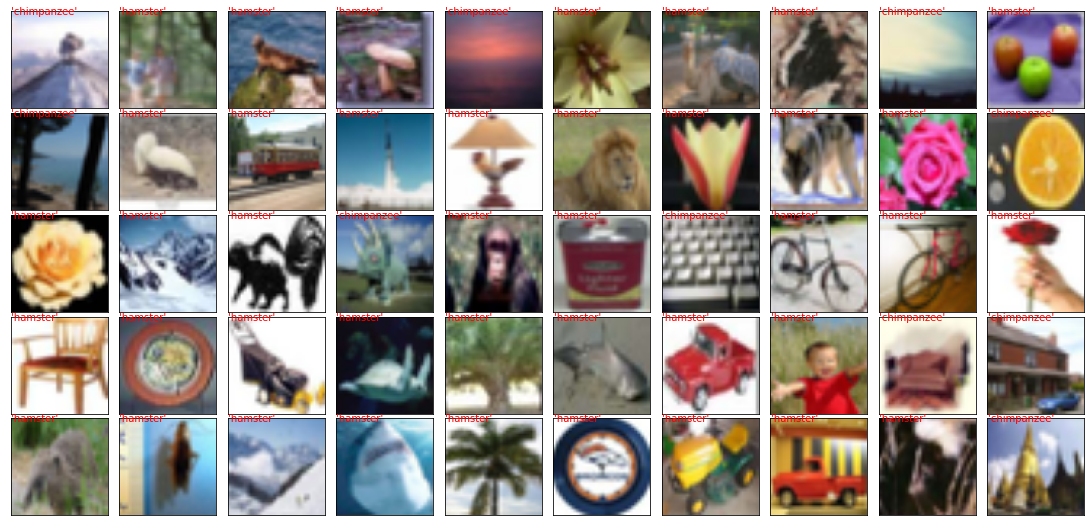

In [13]:
predictionc_values = model.predict_classes(xc1_test)

# set up the figure
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 28x28 pixels
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    _ = ax.imshow(tf.reshape(xc1_test[i,:], [224, 224,3]),cmap=plt.cm.gray_r, interpolation='nearest')

    if predictionc_values[i] == np.argmax(yc1_test[i]):
        # label the image with the blue text
        _ = ax.text(0, 7, class_names[predictionc_values[i]], color='blue')
    else:
        # label the image with the red text
        _ = ax.text(0, 7, class_names[predictionc_values[i]], color='red')

In [14]:
%load_ext tensorboard
%tensorboard --logdir logs/fit --host localhost --port 8089

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 296.